In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import xception,vgg19,mobilenet_v2,ResNet50
from tensorflow.keras import Sequential, Model
import os
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64,64
SEQUENCE_LENGTH = 15

In [4]:
DATASET = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset"
IMAGE_HEIGHT , IMAGE_WIDTH = 64,64
SEQUENCE_LENGTH = 15

total = 300

def frames_extraction(video_path:str):
    frames_list = []
    video_reader = cv.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame/255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

def create_dataset():
    classes = os.listdir(DATASET)

    classes_count = len(classes)

    features = []
    labels = []
    video_file_path = []

    for idx,item in enumerate(classes):
        path = f"{DATASET}/{item}"
        
        print(f"{idx+1}. {item}")

        for videos in tqdm(os.listdir(path)[:total]):
            new_path = path + f"/{videos}"

            frames = frames_extraction(new_path)

            if(len(frames) == SEQUENCE_LENGTH):
                features.append(frames)        
                labels.append(item)
                video_file_path.append(new_path)
    
    features = np.array(features)
    labels = np.array(labels)
    
    distinct = list(set(labels))
    
    l = []

    for items in labels:
        idx = distinct.index(items)
        a = [0]*len(distinct)
        a[idx] = 1
        l.append(a)
    l = np.array(l)
    
#     print("Completed..")
    
    return features,l,distinct,video_file_path

features,labels,distinct,video_file_path = create_dataset()

1. NonViolence


100%|██████████| 300/300 [02:18<00:00,  2.17it/s]


2. Violence


100%|██████████| 300/300 [06:21<00:00,  1.27s/it]


In [5]:
@tf.function
def calculate_frame_difference(video): # for a particular video
    out = []
    for i in range(SEQUENCE_LENGTH - 1):
        out.append(video[i+1] - video[i])
    out.append(out[-1])
    return tf.convert_to_tensor(out)

In [6]:
@tf.function
def background_suppression_image(img):
    m = tf.reduce_mean(img)
    f = img-m
    return f

In [7]:
@tf.function
def list_to_stack(xs):
  xs=tf.stack(xs, axis=1)
  return xs

In [8]:
# background suppression for all videos
@tf.function
def background_suppression_video(video):
  supressed_features = []

  for img in video:
    m = tf.reduce_mean(img)
    f = tf.abs(img - m)
    supressed_features.append(f)

  return tf.convert_to_tensor(supressed_features)
  # return video

In [9]:
def fusion(img1,img2):
  ans = []
  for v in range(len(img1)):
    a = []
    for i in range(len(img1[v])):
      b = Add()([img1[v][i],img2[v][i]])
      a.append(b)
    ans.append(a)
  return np.array(ans)

In [10]:
@tf.function
def choose(x,i):
  return x[:,i]

In [11]:
X_train, X_test,y_train,y_test = train_test_split(features,labels,test_size=0.3)

In [12]:
inp = Input(shape=(SEQUENCE_LENGTH,IMAGE_WIDTH,IMAGE_HEIGHT,3))
f = []
for i in range(0,SEQUENCE_LENGTH,1):
    a = Lambda(lambda s : choose(s,i))(inp)
    a = Lambda(background_suppression_image)(a)
    f.append(a)
x = Lambda(list_to_stack)(f)

print(x.shape)
x = Conv2D(filters=16,kernel_size=(3,3),activation="relu")(x)
x = BatchNormalization(momentum=0.8)(x)
x = Dropout(0.1)(x)
print(x.shape)

x = Conv2D(filters=32,kernel_size=(3,3),activation="relu")(x)
x = BatchNormalization(momentum=0.8)(x)
x = Dropout(0.1)(x)

x = ConvLSTM2D(filters=4,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(x)
x = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(x)
x = TimeDistributed(Dropout(0.2))(x)
print(x.shape)

x = ConvLSTM2D(filters=8,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(x)
x = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(x)
x = TimeDistributed(Dropout(0.2))(x)


x = ConvLSTM2D(filters=16,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(x)
x = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(x)
x = TimeDistributed(Dropout(0.2))(x)
print(x.shape)

(None, 15, 64, 64, 3)
(None, 15, 62, 62, 16)
(None, 15, 29, 29, 4)
(None, 15, 6, 6, 16)


In [13]:
y = Lambda(calculate_frame_difference)(inp)

y = Conv2D(filters=16,kernel_size=(3,3),activation="relu")(inp)
y = BatchNormalization(momentum=0.8)(y)
y = Dropout(0.1)(y)

y = Conv2D(filters=32,kernel_size=(3,3),activation="relu")(y)
y = BatchNormalization(momentum=0.8)(y)
y = Dropout(0.1)(y)

y = ConvLSTM2D(filters=4,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(y)
y = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(y)
y = TimeDistributed(Dropout(0.2))(y)

y = ConvLSTM2D(filters=8,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(y)
y = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(y)
y = TimeDistributed(Dropout(0.2))(y)


y = ConvLSTM2D(filters=16,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(y)
y = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(y)
y = TimeDistributed(Dropout(0.2))(y)

print(y.shape)

(None, 15, 6, 6, 16)


In [14]:
a = Add()([x,y])
z = MultiHeadAttention(num_heads=16,key_dim=64,dropout=0.1)(a,a)
f = Flatten()(a)
x = Dense(64,activation="relu")(f)
x = Dropout(0.2)(x)
out = Dense(len(distinct),activation="softmax")(x)
model = Model(inputs=inp,outputs=out)
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
history = model.fit(X_train,y_train,epochs=25,batch_size=1,validation_split=0.3,shuffle=True)

Epoch 1/25


2023-05-22 17:02:24.246175: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/conv_lstm2d/while/body/_108/model/conv_lstm2d/while/mul_6' -> 'model/conv_lstm2d/while/body/_108/model/conv_lstm2d/while/add_5', 'model/conv_lstm2d/while/body/_108/model/conv_lstm2d/while/convolution_6' -> 'model/conv_lstm2d/while/body/_108/model/conv_lstm2d/while/add_4', 'model/conv_lstm2d/while/body/_108/model/conv_lstm2d/while/clip_by_value' -> 'model/conv_lstm2d/while/body/_108/model/conv_lstm2d/while/mul_7', 'model/conv_lstm2d/while/body/_108/model/conv_lstm2d/while/clip_by_value_2' -> 'model/conv_lstm2d/while/body/_108/model/conv_lstm2d/while/mul_9', 'model/conv_lstm2d_3/while/body/_792/model/conv_lstm2d_3/while/mul_6' -> 'model/conv_lstm2d_3/while/body/_792/model/conv_lstm2d_3/while/add_5', 'model/conv_lstm2d_3/while/body/_792/model/conv_lstm2d_3/while/convolution_6' -> 'mod

294/294 [==============================] - ETA: 0s - loss: 0.7146 - accuracy: 0.5340

2023-05-22 17:04:17.027228: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/conv_lstm2d/while/body/_156/model/conv_lstm2d/while/convolution_6' -> 'model/conv_lstm2d/while/body/_156/model/conv_lstm2d/while/add_4', 'model/conv_lstm2d/while/body/_156/model/conv_lstm2d/while/clip_by_value' -> 'model/conv_lstm2d/while/body/_156/model/conv_lstm2d/while/mul_7', 'model/conv_lstm2d/while/body/_156/model/conv_lstm2d/while/mul_6' -> 'model/conv_lstm2d/while/body/_156/model/conv_lstm2d/while/add_5', 'model/conv_lstm2d/while/body/_156/model/conv_lstm2d/while/clip_by_value_2' -> 'model/conv_lstm2d/while/body/_156/model/conv_lstm2d/while/mul_9', 'model/conv_lstm2d_3/while/body/_108/model/conv_lstm2d_3/while/convolution_6' -> 'model/conv_lstm2d_3/while/body/_108/model/conv_lstm2d_3/while/add_4', 'model/conv_lstm2d_3/while/body/_108/model/conv_lstm2d_3/while/clip_by_value'

294/294 [==============================] - 133s 367ms/step - loss: 0.7146 - accuracy: 0.5340 - val_loss: 0.6400 - val_accuracy: 0.6429
Epoch 2/25
294/294 [==============================] - 108s 369ms/step - loss: 0.7276 - accuracy: 0.5850 - val_loss: 0.6692 - val_accuracy: 0.6429
Epoch 3/25
294/294 [==============================] - 108s 366ms/step - loss: 0.5767 - accuracy: 0.7007 - val_loss: 0.5791 - val_accuracy: 0.6825
Epoch 4/25
294/294 [==============================] - 108s 366ms/step - loss: 0.4868 - accuracy: 0.7823 - val_loss: 0.5444 - val_accuracy: 0.6905
Epoch 5/25
294/294 [==============================] - 109s 372ms/step - loss: 0.4270 - accuracy: 0.8299 - val_loss: 0.5939 - val_accuracy: 0.7222
Epoch 6/25
294/294 [==============================] - 107s 363ms/step - loss: 0.3641 - accuracy: 0.8469 - val_loss: 0.7277 - val_accuracy: 0.7063
Epoch 7/25
294/294 [==============================] - 106s 361ms/step - loss: 0.3009 - accuracy: 0.8776 - val_loss: 0.8320 - val_accura

In [15]:
p = model.predict(X_test)

6/6 [==============================] - 4s 300ms/step


In [16]:
new_p = []
for item in p:
    new_p.append(np.argmax(item))
    

In [17]:
model.evaluate(X_test,y_test)

6/6 [==============================] - 3s 206ms/step - loss: 1.5957 - accuracy: 0.7333


[1.595747709274292, 0.7333333492279053]

In [18]:
pred = []
for item in new_p:
    pred.append(distinct[item])

In [19]:
x = X_test
y = y_test

In [20]:
model.evaluate(x,y)

6/6 [==============================] - 1s 207ms/step - loss: 1.5957 - accuracy: 0.7333


[1.595747709274292, 0.7333333492279053]

In [21]:
p = model.predict(x)

6/6 [==============================] - 1s 218ms/step


In [22]:
new_p = []
for item in p:
    new_p.append(np.argmax(item))    

In [23]:
l = []
for item in y:
    l.append(distinct[np.argmax(item)])

In [24]:
l_pred = []
for item in new_p:
    l_pred.append(distinct[item])

In [25]:
from sklearn.metrics import confusion_matrix,classification_report

In [26]:
cm = confusion_matrix(l,l_pred)

In [27]:
print(cm)

[[63 27]
 [21 69]]


<AxesSubplot: >

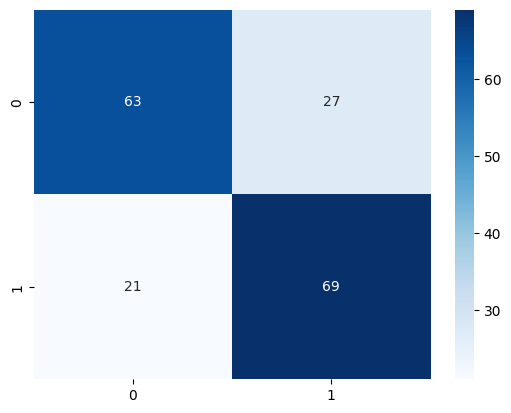

In [28]:
import seaborn as sns

sns.heatmap(cm,annot=True,cmap="Blues")

In [29]:
print(classification_report(l,l_pred))

              precision    recall  f1-score   support

 NonViolence       0.75      0.70      0.72        90
    Violence       0.72      0.77      0.74        90

    accuracy                           0.73       180
   macro avg       0.73      0.73      0.73       180
weighted avg       0.73      0.73      0.73       180



In [30]:
len(l)

180